# Estimating a simpel model by simulated minimum distance (SMD)

**Inspiration:** This notebook is based on SMD.ipynb notebook from last lecture, which is again based on a [Bradley Setzler's blog post](https://juliaeconomics.com/tag/method-of-simulated-moments/).

**Download Julia:**
- [Open source version](https://julialang.org/downloads/)
- [JuliaPro from Julia Computing (bundled with IDE and notebook support)](https://juliacomputing.com/products/juliapro)

[Documentation** (language and about 1900 packages)](https://pkg.julialang.org/docs/)

**Julia community:**
- [Discourse](https://discourse.julialang.org)
- [Slack](https://julialang.slack.com)

For **introductory material on Julia for Economists**, see [https://lectures.quantecon.org/jl/](https://lectures.quantecon.org/jl/).

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2019/master?urlpath=lab/tree/13/SMD.ipynb)

**Some initial setup:**

In [1]:
using Random, Statistics, PyPlot, Optim
include("model.jl"); # use trailing semi-colon to suppress output

# The economic model

Let $c_i$ denote consumption and $0 ⩽ l_i \leqslant 1$ denote leisure. Consider an agent who wishes to maximize Cobb-Douglas utility over consumption and leisure subject to a budget constraint. That is
$$
\max_{c_i,l_i} c_i^\gamma l_i^{1-\gamma}\\
\mathrm{s.t.} \\
c_i \leqslant (1 - τ) w_i (1 - l_i) + \varepsilon_i
$$

where $0 \leqslant \gamma \leqslant 1$ is the relative preference for consumption, $w_i$ is wage earned from supplying labor, $\tau$ is the tax rate and $\varepsilon_i$ is a non-labor income shock.

This model has a closes form solution given by:

$$
c^\star (w_i,\varepsilon_i;\gamma) = \gamma (1 - \tau) w_i +\gamma \varepsilon_i \\
l^\star(w_i,\varepsilon_i;\gamma) = (1 - \gamma) +\frac{(1 - \gamma)\varepsilon_i}{(1 - \tau) w_i}
$$

# The empirical goal

We will impose a set of simplifying assumptions:

- The unobserved income shock is iid with known distribution, $\varepsilon_i \sim N(0,\sigma^2)$.
- The individual wages, $w_i$, are observed along with consumption and labor choices for $n=10,000$ individuals.

The goal is to estimate the relative preference for consumption and leisure, $\gamma$, and the tax rate, $\tau$ in this model. The set of parameters to be estimated thus is $\theta=(\gamma,\tau,\sigma)$.

To this end, we assume that we have a dataset consisting of $\{w_i,c_i,l_i\}_{i=1}^n$. To simulate such a dataset we run the following code.

In [2]:
# a. true parameters in the data generating process
### in Julia, it is often convenient to use NamedTuples for storing parameters
θ = (γ=0.5, τ=0.2, σ=1.0)

# b. simulate observed dataset
### for reproducibility, it is a good idea, to explicitly pass a RNG (here MersenneTwister)
### object to the random number functions
rng = MersenneTwister(123)
n = 10_000

## stochastic variables
### distribution of log-wages are (arbitrarily) chosen to be standard normal
w = exp.(randn(rng, n))
e = θ.σ*randn(rng, n)

# optimal choices
### we use the dot-syntax `foo.`` to make the function *broadcast* over all elements of the
### arrays and we use `Ref` to signal that an argument should be treated as a scalar in the
### broadcast operation.
con = Model.c_star.(w, e, Ref(θ))
lab = Model.l_star.(w, e, Ref(θ));

# Visualizing the data

We could imagine plotting the scatter of consumption and labor supply against wages.

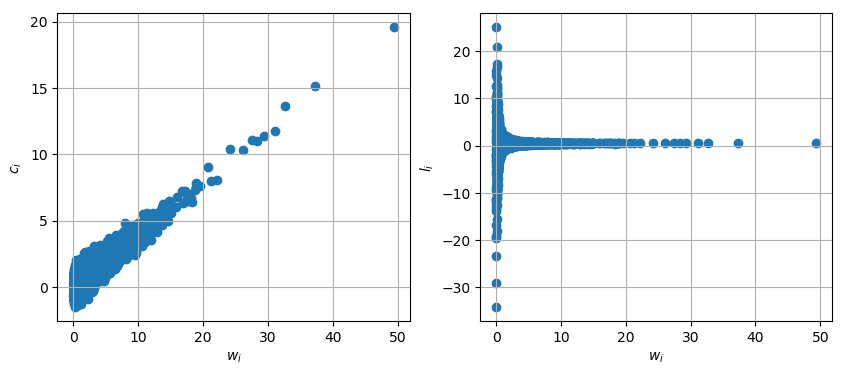

In [3]:
### There are several plotting packages in Julia but for here we use the PyPlot.jl package
### which wraps Python's matplotlib. Notice, that it is possible to reuse much of the
### Python syntax dispite this being evaluated as normal Julia code.

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(w, con)
ax.grid(true)
ax.set_xlabel(raw"$w_i$")
ax.set_ylabel(raw"$c_i$")

ax = fig.add_subplot(1,2,2)
ax.scatter(w, lab)
ax.grid(true)
ax.set_xlabel(raw"$w_i$")
ax.set_ylabel(raw"$l_i$");

We note that there is a clear relationship between consumption and wages. We could thus imagine estimating the two parameters in $\theta$ using the correlation between the consumption and wages, the average labor supply and the variance of consumption.

# Identification

From the solution we note that the correlation between wages and consumption depends on $γ$ and $\tau$, the mean of the labor supply should be $1 - \gamma$ and that the variance of consumption should be proportional to the variance of $varepsilon$, $\sigma^2$. These moments, in turn, should be able to identify the parameters in $\theta$.

We can denote the moments in the data as $\Lambda^{\mathrm{data}} = (\mathrm{corr}(w_i, c_i), \mathrm{mean}(l_i), \mathrm{var}(c_i))$ and calculate them as:

In [4]:
moments_fun = (w, con, lab) -> (cor(w, con), mean(lab), var(con))
mom_data = moments_fun(w, con, lab)
mom_data

(0.8673269168418695, 0.4810790538523146, 1.0050937857814541)

# An SMD Estimator

We can then estimate $\theta$ by minimizing the squared distance between the empirical moments in the data, $\Lambda^\mathrm{data}$, and the same moments calculated from $S=100$ simulated agents for each of the $n$ values of $w_i$ from the model for each guess of $\theta$, $\Lambda^\mathrm{sim}(\theta;w)$.

Specifically, we simulate draws of $\{\varepsilon_i^{(s)}\}_{i=1,s=1}^{n,S}$,calculate the synthetic dataset for a value of $\theta$, $\{w_i, s_i^{(s)}, l_i^{(s)}\}_{i=1,s=1}^{n,S}$, and stack these $n\times S$ observations to calculate the moments above to get $Λ^\mathrm{sim}(\theta;w)$.

Our **SMD estimator** is

$$
\hat{\theta} = \arg \min_\theta Q(\theta;w)
$$

where the objective function is $Q(\theta,w) = \|\Lambda^\mathrm{data} - \Lambda^\mathrm{sim}(\theta,w)\|^2$

The objective function could be coded as done in the `obj_fun`. In the `model.jl` file.

# Objective function

We specify which parameters to be estimated and construct initial starting values as

In [5]:
θ₀ = (γ=0.4, τ=0.15, σ=0.9)  # initial guesses

(γ = 0.4, τ = 0.15, σ = 0.9)

And we can evaluate the objective function as

In [6]:
obj_at_θ₀ = Model.obj_fun(θ₀, w, mom_data, moments_fun)

0.12185671913345228

# Call optimizer
We then call an unconstained optimizer using numerical gradients with option to print iterations

In [7]:
### The optimization function passes a `Vector` to the objective function so first we have
### to construct a `NamedTuple` from the `Vector`

obj_fun = vθ -> Model.obj_fun((γ=vθ[1], τ=vθ[2], σ=vθ[3]), w, mom_data, moments_fun)

results = optimize(obj_fun, [θ₀...], BFGS()) # [θ₀...] converts the NamedTuple to a Vector

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.4,0.15,0.9]
 * Minimizer: [0.520726900724164,0.23427069484126523, ...]
 * Minimum: 9.384266e-20
 * Iterations: 9
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.52e-07 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.76e+05 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 3.69e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 24
 * Gradient Calls: 24

In [8]:
println("True value:", θ₀)
println("Estimated value:", NamedTuple{keys(θ₀)}(round.(results.minimizer, digits=2)))

True value:(γ = 0.4, τ = 0.15, σ = 0.9)
Estimated value:(γ = 0.52, τ = 0.23, σ = 0.96)
